# Caso práctico: Estimación por subespacios e implementación de observadores para el diseño de sensores inteligentes.

## Planteamiento

Se considera un sistema *masa-resorte*, representado en la Figura 1:

```{figure} images/masaresorte.png
---
height: 300px
name: directive1-fig
---
Sistema Masa-Resorte. Imagen obtenida de {cite}`masa_resorte`.
```

Dicho sistema fue implementado y, mediante una tarjeta de adquisición de datos, se registró la posición de la masa a lo largo del tiempo. Por lo tanto, se tiene acceso a la señal $x(t)$. Sin embargo, a pesar de conocer la dinámica del sistema y la salida, no se dispone de información sobre los parámetros físicos del sistema ni sobre las condiciones iniciales.

El propósito de este capítulo es estimar los parámetros físicos del sistema e implementar un observador de estados para estimar la velocidad.

Aunque el sistema *masa-resorte* es, en un caso ideal, un sistema oscilatorio, en condiciones reales existe cierto rozamiento de la masa con el aire, lo que genera un efecto de fricción. Como consecuencia, este sistema puede modelarse más adecuadamente como un *masa-resorte-amortiguador*. A partir de la estimación de los parámetros del sistema, es posible también determinar el coeficiente de fricción viscosa y, con ello, diseñar un viscosímetro.


In [64]:
# Ejecutar esta celda primero.
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.signal import savgol_filter
from IPython.display import HTML, display, Math

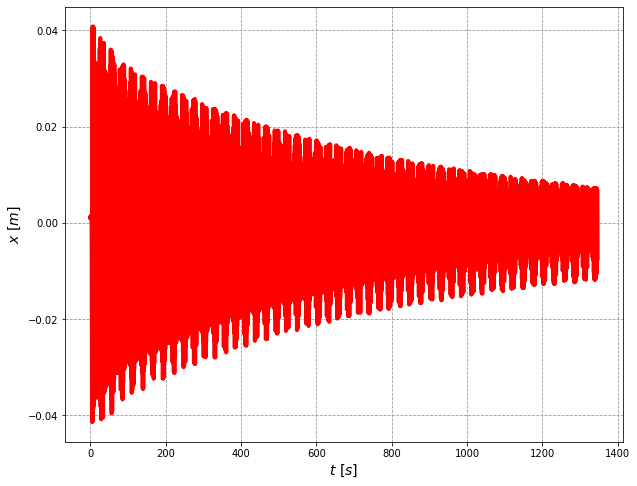

In [65]:
# Lectura de datos
data = np.loadtxt('sources/datos.csv', delimiter = ',')

# Vectores de tiempo y posición
t = data[:, 0]
pos = data[:, 1]


# Gráfica de los datos obtenidos
plt.figure(figsize=(10, 8))
plt.plot(t, pos, 'r-', linewidth=4)
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel(r'$t\ [s]$', fontsize=14)
plt.ylabel(r'$x\ [m]$', fontsize=14)
plt.show()

Dado que este sistema es autónomo, no posee una entrada, y la salida depende exclusivamente de las condiciones iniciales. En este contexto, solo se tiene acceso a la salida del sistema, sin conocimiento previo de sus parámetros físicos ni de sus condiciones iniciales. Para abordar este problema, se emplea el método de identificación por subespacios `N4SID`.

## Estimación por subespacios

El método N4SID (*Numerical Subspace State Space System Identification*) es una técnica eficiente y robusta para estimar modelos en espacio de estados a partir de datos de entrada y salida de un sistema dinámico. Este enfoque destaca por su capacidad de identificar directamente las matrices del modelo (𝐴,𝐵,𝐶,𝐷) sin requerir modelos iniciales o ajustes iterativos complejos.


`N4SID` se basa en técnicas de álgebra lineal, como la descomposición en valores singulares (SVD), para extraer la información dinámica del sistema desde los datos. Utiliza conceptos de subespacios numéricos para separar el comportamiento del sistema del ruido, asegurando una estimación precisa y estable, incluso en presencia de ruido significativo. Este, es computacionalmente rápido y adecuado para sistemas de múltiples entradas y múltiples salidas (MIMO) y permite obtener modelos en espacio de estados sin requerir modelos paramétricos previos, simplificando el proceso de identificación.

Por estas razones, `N4SID` es ideal para estimar modelos en espacio de estados que capturen la dinámica del sistema. El uso de este algoritmo, se realiza mediante el System Identification Toolbox de MATLAB, utilizando la siguiente linea de comandos:

`n4sid(Signal, 2, 'Form', 'canonical', 'Ts', 0)`

En este caso le propocionamos los datos mediante el vector llamado `Signal`, en este caso se nos arroja un modelo en espacio de estados con la siguiente forma

$$\dot{\mathbf{x}} = \mathbf{A}\mathbf{x} + \mathbf{K}e$$

$$y = \mathbf{C}\mathbf{x} + e$$

donde $e$ representa las perturbaciones no modeladas y los errores inherentes al proceso de medición, considerándose una señal de ruido blanco con varianza constante. Por otro lado, la matriz $\mathbf{K}$ conocida como *componente de perturbación* y se interpreta como la manera en que el ruido se introduce y afecta los estados del sistema dinámico. 

Tras realizar la estimación antes mencionada, nos arroja un 98% de ajuste, siendo las matrices antes mencionadas las siguientes:

$$\mathbf{A} = \begin{bmatrix}
0 & 1  \\ 
-15.07 & -0.00135
\end{bmatrix} \quad \mathbf{C} = \begin{bmatrix}
1 & 0
\end{bmatrix} \quad \mathbf{K}  = \begin{bmatrix}
4.323  \\ 
0.5977
\end{bmatrix}$$

Es importante mencionar que la forma de la matriz $A$ estimada es en su forma canónica controlable y dicha estimación se realizó en tiempo continuo.

Como se mencionó previamente, aunque el sistema es un **masa-resorte**, en condiciones reales debe modelarse como un **masa-resorte-amortiguador** debido a la presencia de fricción. Este es un sistema bien conocido, cuya representación en forma canónica controlable es:

$$\mathbf{A} = \begin{bmatrix}
0 & 1  \\ 
-\frac{k}{m} & -\frac{b}{m}
\end{bmatrix}$$

donde $m$ es la masa, $b$ es el coeficiente de fricción o el coeficiente de amortiguamiento y $k$ es la constante del resorte. 

Dado que se tiene acceso al sistema físico, es posible conocer la masa y, mediante pruebas experimentales, determinar la constante del resorte. Los valores teóricos de estos parámetros son:

$$m_{teo} = 698.4[g] \quad k_{teo} = 10[N/m]$$

Con estos valores, se puede calcular el error absoluto porcentual en la estimación del cociente $\frac{k}{m}$

In [66]:
m_teo, k_teo = 0.6984, 10
c_km_teo = k_teo / m_teo
c_km_est = 15.07

error_est = np.abs((c_km_teo - c_km_est) / c_km_teo) * 100

display(Math(f"\\text{{Cociente estimado }} \\hat{{\\frac{{k}}{{m}}}} : {c_km_est:.2f} \\; \\left[ \\mathrm{{\\frac{{N}}{{kg \\cdot m}}}} \\right]"))
display(Math(f"\\text{{Cociente real }} \\frac{{k}}{{m}} : {c_km_teo:.3f} \\; \\left[ \\mathrm{{\\frac{{N}}{{kg \\cdot m}}}} \\right]"))
display(Math(f"\\text{{Error absoluto porcentual del cociente  }}: {error_est:.2f}\\%"))


<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Se tiene un error menor al $6\%$, por lo que se puede considerar una estimación precisa. A partir de esto, es posible determinar el coeficiente de fricción del aire como

In [67]:
c_bm_est = 0.00135

b_est = c_bm_est * m_teo

display(Math(f"\\text{{Coeficiente de fricción del aire }} \\hat{{b}} : {b_est:.5f} \\; \\left[ \\mathrm{{\\frac{{N \\cdot s}}{{ m}}}} \\right]"))

<IPython.core.display.Math object>

Por lo tanto, hasta el momento, con un sensor de posición y el conocimiento de un parámetro del sistema, como la masa, es posible estimar otros dos parámetros: la constante del resorte y el coeficiente de fricción del aire. Esto puede aplicarse en viscosímetros, donde, a partir de este parámetro y situando el sistema en otro fluido, como el agua, se puede determinar la viscosidad del fluido.

Ahora bien, es posible implementar un observador de estados para estimar la velocidad de la masa.

## Implementación de Observador de estados.

La dinámica del observador se expresa como

$$\dot{\hat{\mathbf{x}}} = \mathbf{A}\hat{\mathbf{x}} + \mathbf{L}(y-\hat{y})$$

$$\hat{y} = \mathbf{C}\hat{\mathbf{x}}$$

donde L es la ganancia del observador. Esta ganancia la podemos obtener mediante la siguiente condición

$$|sI-A+LC| = 0$$

Dado que el sistema es observable, es posible ubicar los polos del observador en cualquier posición deseada. Con base en esto, se puede diseñar una función que calcule la ganancia del observador a partir de la elección de sus polos, como se muestra a continuación.

In [68]:

def cal_obs_gain(lamb1, lamb2, A):
    """
    Esta función retorna el vector L con la ganancia del observador, tras recibir los polos
    deseados del observador y la matriz A del sistema.

    Parámetros:
    lamb1 : float
        Polo 1 del observador.
    lamb2 : float
        Polo 2 del observador.
    A : ndarray
        Matriz A del sistema.

    Retorna:
    _ : ndarray
        Ganancias del observador L.
    """
    L1 = lamb1 + lamb2 - np.abs(A[1,1])
    L2 = (lamb1 * lamb2) - (np.abs(A[1,1]) * L1) - np.abs(A[1,0])
    return np.array([[L1], [L2]])

#  Esta función no es general y fue desarrollada para este caso.

In [69]:
# Polos del observador para modificar
lamb1 = 20
lamb2 = 20

In [70]:

# Matrices del sistema estimadas con N4SID
A = np.array([[0, 1], [-15.07, -0.00135]])
C = np.array([[1, 0]])  # Solo medimos la posición

# Función para obtener `y`
def get_y(t_query, t, y):
    idx = np.searchsorted(t, t_query, side="left")
    idx = np.clip(idx, 0, len(y) - 1)  # Evitar índices fuera de rango
    return np.array([[y[idx]]])

# Definir la ecuación del observador
def observador(t, x_hat, A, C, L, t_data, y_data):
    y = get_y(t, t_data, y_data)  # Obtener y en el instante dado
    y_hat = C @ x_hat.reshape(-1, 1)  # Salida estimada
    dx_hat = A @ x_hat.reshape(-1, 1) + L @ (y - y_hat)  # Ecuación del observador
    return dx_hat.flatten()

# Ganancias del observador
L = cal_obs_gain(lamb1, lamb2, A)

# Condición inicial del observador
x0_hat = np.array([0, 0])

# Resolver la ecuación del observador con los datos reales
t_span = (t[0], t[-1])
sol_hat = solve_ivp(observador, t_span, x0_hat, args=(A, C, L, t, pos), t_eval=t)  


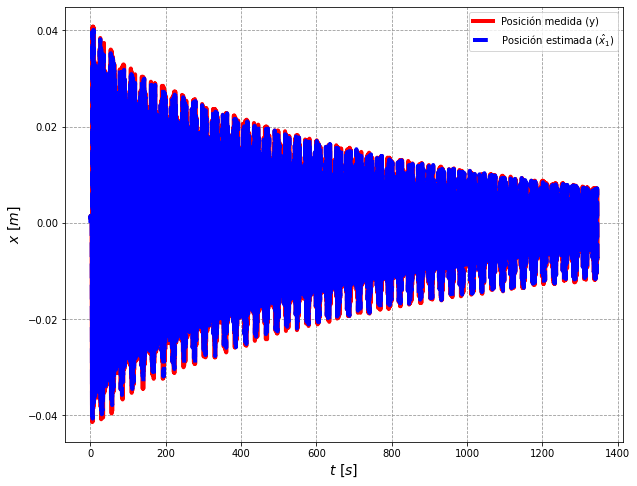

In [71]:
# Graficar resultado
plt.figure(figsize=(10, 8))
plt.plot(t, pos, label="Posición medida (y)", color ='r', linewidth = 4)
plt.plot(sol_hat.t, sol_hat.y[0], label="Posición estimada ($\hat{x}_1$)", linestyle="dashed", color ='b', linewidth = 4)
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel(r'$t\ [s]$', fontsize=14)
plt.ylabel(r'$x\ [m]$', fontsize=14)
plt.legend()
plt.show()

Se puede apreciar de la imagen anterior que el observador estima correctamente la posición, pero veamos el desarrollo del error  en la siguiente gráfica

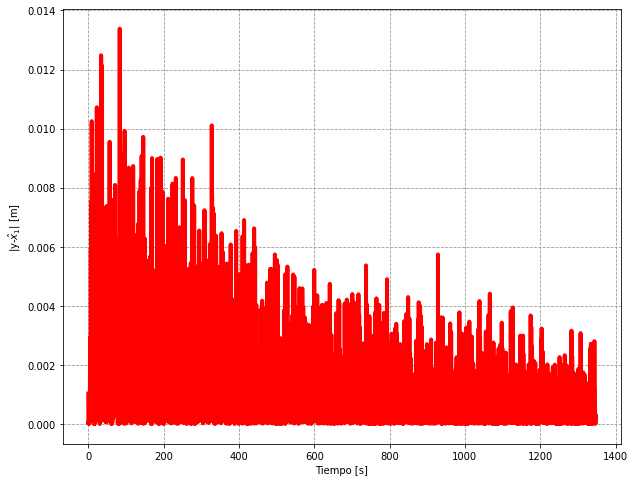

In [72]:
# Graficar el error 
error = np.abs(sol_hat.y[0] - pos)

plt.figure(figsize=(10, 8))
plt.plot(t, error, 'r-', linewidth = 4)
plt.xlabel("Tiempo [s]")
plt.ylabel("|y-$\hat{x}_1$| [m]")
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.show()

Se puede observar que el error es muy pequeño y que su magnitud decrece con el tiempo. Finalmente, se analizará la estimación de la velocidad, comparándola con la obtenida al derivar los datos de la posición medida (afectados por ruido de medición) y con la estimación obtenida mediante el filtro de Savitzky-Golay.

El filtro de Savitzky-Golay es una técnica utilizada para suavizar señales y calcular derivadas sin perder información relevante, especialmente en señales ruidosas. Su fundamento radica en el ajuste de polinomios locales mediante el método de mínimos cuadrados, lo que permite reducir el impacto del ruido en la estimación de la derivada.

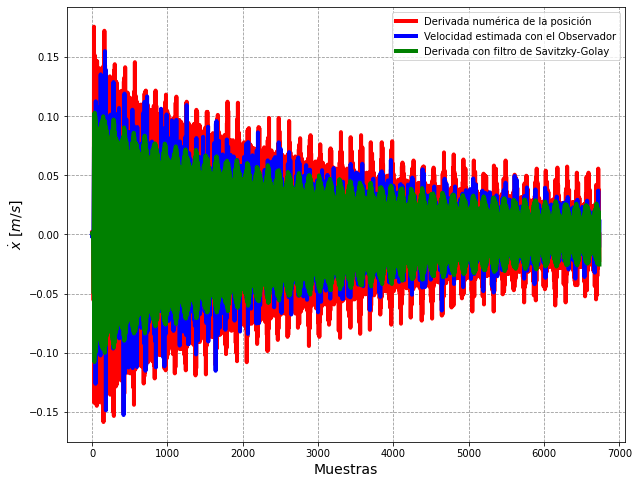

In [73]:
# Derivada numérica de la posición
dx = t[1] - t[0]
vel_diff = np.diff(pos) / dx

# Derivada con el filtro de Savitzky-Golay
vel_fil = savgol_filter(pos, window_length=11, polyorder=3, deriv=1, delta=dx)

# Gráfica comparativa de la velocidad
plt.figure(figsize=(10, 8))
plt.plot(vel_diff, 'r-', linewidth=4, label="Derivada numérica de la posición")
plt.plot(sol_hat.y[1], 'b-',label="Velocidad estimada con el Observador", linewidth=4)
plt.plot(vel_fil, 'g-', linewidth=4, label="Derivada con filtro de Savitzky-Golay")
plt.grid(True, linestyle='--', color=(0.6, 0.6, 0.6))
plt.xlabel('Muestras', fontsize=14)
plt.ylabel(r'$\dot{x}\ [m/s]$', fontsize=14)
plt.legend()
plt.show()

## Discusión

En la última gráfica presentada, se pueden observar tres métodos distintos para estimar la velocidad. La derivada numérica, que es computacionalmente más económica, presenta un alto nivel de ruido, lo cual es común en las diferenciaciones numéricas directas debido a la amplificación de errores en datos discretos. Por otro lado, la estimación mediante el observador reduce el ruido en comparación con la derivada numérica, aunque aún presenta variaciones considerables. Finalmente, el uso del filtro de Savitzky-Golay suaviza significativamente los datos, eliminando gran parte del ruido sin distorsionar la tendencia general de la señal. Sin embargo, este método no considera la dinámica del sistema, por lo que no es óptimo cuando se dispone de un modelo conocido, como en este caso.

Esto sugiere que el uso de filtros de suavizado es una estrategia útil cuando se desea calcular derivadas sin amplificar el ruido en aplicaciones fuera de línea con altas tasas de muestreo. No obstante, en aplicaciones en tiempo real, el observador resulta más estable y adecuado si se cuenta con el modelo del sistema, siendo este el estimado a partir de los datos mediante N4SID.

En conclusión, se ha demostrado que, con un simple sensor de posición y un microcontrolador, es posible implementar algoritmos que doten de inteligencia al sensor, permitiéndole estimar parámetros físicos del sistema a medir, como el coeficiente del resorte y el coeficiente de fricción, así como estados del sistema, como la velocidad e incluso la aceleración.